<a href="https://colab.research.google.com/github/sapperka/AZSII/blob/main/%D0%90%D0%97%D0%A1%D0%98%D0%98_%D0%91%D0%91%D0%9C%D0%9E_02_23_%D0%A0%D1%8B%D0%B1%D0%B0%D0%BA%D0%BE%D0%B2_%D0%9F%D0%A07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# АЗСИИ

## Практика 7: Создание и использование генеративных противоречивых примеров (GANbased Adversarial Examples)

Группа: ББМО-02-23

Студент: Рыбаков Владислав Андреевич

## Цель задания:
Изучить использование генеративных моделей (GAN — Generative Adversarial Networks) для
создания противоречивых примеров. В этом задании мы создадим противоречивые примеры с
использованием GAN и проверим их влияние на модели классификации.

## Задачи:
1. Изучить концепцию генеративных противоречивых примеров.
2. Реализовать простую GAN для создания противоречивых изображений.
3. Оценить точность моделей классификации на противоречивых примерах, созданных с помощью GAN.
4. Сравнить атаку на обе модели (полносвязную и свёрточную сети).

## Шаги выполнения:

### Шаг 1: Концепция генеративных противоречивых примеров

Генеративные противоречивые примеры — это изображения, созданные генеративными моделями,
которые могут обманывать модели классификации. В отличие от стандартных атак (например, FGSM
или PGD), где добавляются малые шумы, GAN могут генерировать реалистичные, но сложные для
распознавания модели изображения, которые сложно отличить от настоящих данных.

### Шаг 2: Создание простой GAN для генерации противоречивых примеров

Мы создадим генеративную состязательную сеть (GAN), состоящую из двух частей: генератора и
дискриминатора. Генератор будет создавать изображения, а дискриминатор — пытаться распознать
поддельные изображения.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K


In [2]:
# Загрузка данных MNIST
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Добавление одного измерения (для работы CNN)
train_images = np.expand_dims(train_images, axis=-1)

In [4]:
# Генератор:
def build_generator():
  model = tf.keras.Sequential()
  model.add(layers.Dense(128, activation='relu', input_dim=100))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Dense(784, activation='tanh'))
  model.add(layers.Reshape((28, 28, 1)))
  return model


In [5]:
# Дискриминатор:
def build_discriminator():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=(28, 28, 1)))
  model.add(layers.LeakyReLU())
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
  return model

In [6]:
# Создание моделей:
generator = build_generator()
discriminator = build_discriminator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Компиляция дискриминатора
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
# Создание GAN:
gan_input = layers.Input(shape=(100,))
generated_image = generator(gan_input)
discriminator.trainable = False
validity = discriminator(generated_image)
gan = tf.keras.Model(gan_input, validity)
gan.compile(optimizer='adam', loss='binary_crossentropy')

In [9]:
# Функция обучения GAN:
def train_gan(generator, discriminator, gan, epochs=1000, batch_size=64):
  half_batch = batch_size // 2
  for epoch in range(epochs):
  # Обучение дискриминатора:
      idx = np.random.randint(0, train_images.shape[0], half_batch)
      real_images = train_images[idx]
      noise = np.random.normal(0, 1, (half_batch, 100))
      fake_images = generator.predict(noise)
      real_labels = np.ones((half_batch, 1))
      fake_labels = np.zeros((half_batch, 1))
      d_loss_real = discriminator.train_on_batch(real_images, real_labels)
      d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
  # Обучение генератора через дискриминатор:
      noise = np.random.normal(0, 1, (batch_size, 100))
      valid_labels = np.ones((batch_size, 1))
      g_loss = gan.train_on_batch(noise, valid_labels)
      if epoch % 100 == 0:
        print(f'{epoch} [D loss: {0.5 * np.add(d_loss_real, d_loss_fake)}] [G loss: {g_loss}]')
      K.clear_session()
# Обучение GAN:
train_gan(generator, discriminator, gan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: [0.7301847 0.296875 ]] [G loss: [array(0.6989869, dtype=float32), array(0.6989869, dtype=float32), array(0.53125, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

### Шаг 3: Генерация противоречивых примеров с помощью GAN

Теперь мы сгенерируем противоречивые примеры, используя обученный генератор GAN.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


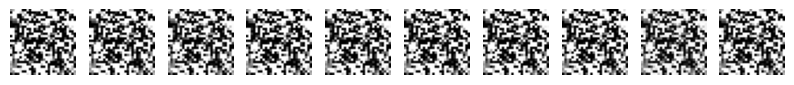

In [10]:
# Генерация противоречивых примеров
def generate_adversarial_examples(generator, n_samples):
  noise = np.random.normal(0, 1, (n_samples, 100))
  generated_images = generator.predict(noise)
  return generated_images

# Генерация 100 примеров
adversarial_images = generate_adversarial_examples(generator, 100)

# Визуализация противоречивых примеров
plt.figure(figsize=(10, 10))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.imshow(adversarial_images[i].reshape(28, 28), cmap='gray')
  plt.axis('off')
plt.show()

### Шаг 4: Оценка моделей на противоречивых примерах

Теперь проверим, как обученные модели (полносвязная сеть и CNN) справляются с
противоречивыми примерами, созданными с помощью GAN.

In [12]:
# Загрузка обученных моделей
model1 = tf.keras.models.load_model('mnist_model1.h5')
model2 = tf.keras.models.load_model('mnist_model2.h5')

# Оценка первой модели на противоречивых примерах
adv_images_reshaped = adversarial_images.reshape(-1, 28, 28, 1)
loss1, acc1 = model1.evaluate(adv_images_reshaped, np.ones((100, 10))) #Примерные метки
print(f'Accuracy of model1 on adversarial GAN examples: {acc1}')

# Оценка второй модели на противоречивых примерах
loss2, acc2 = model2.evaluate(adv_images_reshaped, np.ones((100, 10))) #Примерные метки
print(f'Accuracy of model2 on adversarial GAN examples: {acc2}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 277.5648  
Accuracy of model1 on adversarial GAN examples: 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 808.7701  
Accuracy of model2 on adversarial GAN examples: 0.0


### Шаг 5: Анализ результатов



Оба классификатора продемонстрировали нулевую точность при тестировании на противоречивых примерах, что указывает на их полную уязвимость к атакам с использованием генеративных состязательных сетей (GAN). Сгенерированные данные оказались достаточно реалистичными и сложными для корректного распознавания, что подтверждает высокую эффективность GAN в создании таких примеров. Для повышения устойчивости моделей к подобным атакам следует внедрить защитные меры, такие как обучение на противоречивых примерах (Adversarial Training), регуляризацию и оптимизацию архитектуры.